In [17]:
%cd /content/drive/MyDrive/랭체인 AI 영상객체탐지분석 플랫폼 구축_과제/data

/content/drive/MyDrive/랭체인 AI 영상객체탐지분석 플랫폼 구축_과제/data


In [18]:
!unzip -q "/content/drive/MyDrive/랭체인 AI 영상객체탐지분석 플랫폼 구축_과제/data/fittogether.zip" -d "/content/drive/MyDrive/랭체인 AI 영상객체탐지분석 플랫폼 구축_과제/fittogether"

In [1]:
%cd /content/drive/MyDrive/랭체인 AI 영상객체탐지분석 플랫폼 구축_과제/fittogether/

/content/drive/MyDrive/랭체인 AI 영상객체탐지분석 플랫폼 구축_과제/fittogether


In [20]:
# images / annotations 폴더 생성
!mkdir -p "/content/drive/MyDrive/랭체인 AI 영상객체탐지분석 플랫폼 구축_과제/fittogether/images"
!mkdir -p "/content/drive/MyDrive/랭체인 AI 영상객체탐지분석 플랫폼 구축_과제/fittogether/annotations"

# jpg 파일 이동
!mv "/content/drive/MyDrive/랭체인 AI 영상객체탐지분석 플랫폼 구축_과제/fittogether/"*.jpg \
   "/content/drive/MyDrive/랭체인 AI 영상객체탐지분석 플랫폼 구축_과제/fittogether/images/"

# json 파일 이동
!mv "/content/drive/MyDrive/랭체인 AI 영상객체탐지분석 플랫폼 구축_과제/fittogether/"*.json \
   "/content/drive/MyDrive/랭체인 AI 영상객체탐지분석 플랫폼 구축_과제/fittogether/annotations/"


In [21]:
import os
import random

IMG_DIR  = "/content/drive/MyDrive/랭체인 AI 영상객체탐지분석 플랫폼 구축_과제/fittogether/images"
JSON_DIR = "/content/drive/MyDrive/랭체인 AI 영상객체탐지분석 플랫폼 구축_과제/fittogether/annotations"

# 데이터가 너무 많아서 1000개로 축소
N = 1000  # 남길 개수

# json 기준으로 이름 추출
json_files = [f for f in os.listdir(JSON_DIR) if f.endswith(".json")]
keep = set(random.sample(json_files, N))

for jf in json_files:
    if jf not in keep:
        # json 삭제
        os.remove(os.path.join(JSON_DIR, jf))

        # 대응 image 삭제
        img_name = jf.replace(".json", ".jpg")
        img_path = os.path.join(IMG_DIR, img_name)
        if os.path.exists(img_path):
            os.remove(img_path)


In [22]:
print(len(os.listdir(IMG_DIR)), len(os.listdir(JSON_DIR)))

1000 1000


In [2]:
!pip install ultralytics opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 62.6 MB/s eta 0:00:00


In [3]:
import os
import random
import shutil
import cv2
import glob
import json
import yaml
import ultralytics
import matplotlib.pyplot as plt
from torchvision import transforms
from tqdm import tqdm # 반복문의 진행률을 보여주는 모듈
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator # 박스를 그리는 모듈

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
ultralytics.checks()

Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 38.6/112.6 GB disk)


In [25]:
%pwd

'/content/drive/MyDrive/랭체인 AI 영상객체탐지분석 플랫폼 구축_과제/fittogether'

In [26]:
data_path = '/content/drive/MyDrive/랭체인 AI 영상객체탐지분석 플랫폼 구축_과제'
file_path = f'{data_path}/fittogether'
pjt_path = f'{file_path}/project'

train_root = f'{pjt_path}/train'
valid_root = f'{pjt_path}/valid'
test_root  = f'{pjt_path}/test'

for folder in [train_root, valid_root, test_root]:
    os.makedirs(folder, exist_ok=True)

    for s in ['images', 'labels']:
        os.makedirs(f'{folder}/{s}', exist_ok=True)

In [27]:
from sklearn.model_selection import train_test_split

# 경로
IMG_DIR = f'{file_path}/images'
ANN_DIR = f'{file_path}/annotations'

# 파일 리스트
img_list = sorted(os.listdir(IMG_DIR))
annotation_list = sorted(os.listdir(ANN_DIR))

print(len(img_list), len(annotation_list))

1000 1000


In [28]:
# 확장자 제거해서 ID 기준으로 사용
img_ids = [os.path.splitext(f)[0] for f in img_list]
img_ids[0]

'video_01_000056'

In [29]:
# image data split(train, val, test)
img_train, img_temp = train_test_split(
    img_ids,
    test_size=0.3,
    random_state=2026,
    shuffle=True
)

print(len(img_train), len(img_temp))

700 300


In [30]:
# img_temp를 validation, test로 각각 또 나눈다.
img_val, img_test = train_test_split(
    img_temp,
    test_size=0.5,
    random_state=2026,
    shuffle=True
)

print(len(img_val), len(img_test))

150 150


In [31]:
# annotation, image 학습/테스트 비율 똑같게
ann_train = [f"{i}.json" for i in img_train]
ann_val   = [f"{i}.json" for i in img_val]
ann_test  = [f"{i}.json" for i in img_test]

print(len(ann_train), len(ann_val), len(ann_test))

700 150 150


In [35]:
import shutil

IMG_SRC = "/content/drive/MyDrive/랭체인 AI 영상객체탐지분석 플랫폼 구축_과제/fittogether/images"
ANN_SRC = "/content/drive/MyDrive/랭체인 AI 영상객체탐지분석 플랫폼 구축_과제/fittogether/annotations"

def copy_split(img_ids, split):
    img_dst = f"{BASE_PATH}/{split}/images"
    ann_dst = f"{BASE_PATH}/{split}/labels"

    for i in img_ids:
        shutil.copy(f"{IMG_SRC}/{i}.jpg", f"{img_dst}/{i}.jpg")
        shutil.copy(f"{ANN_SRC}/{i}.json", f"{ann_dst}/{i}.json")

In [36]:
copy_split(img_train, "train")
copy_split(img_val,   "valid")
copy_split(img_test,  "test")

In [37]:
print(len(os.listdir(f"{pjt_path}/train/images")),
      len(os.listdir(f"{pjt_path}/train/labels")))

print(len(os.listdir(f"{pjt_path}/valid/images")),
      len(os.listdir(f"{pjt_path}/valid/labels")))

print(len(os.listdir(f"{pjt_path}/test/images")),
      len(os.listdir(f"{pjt_path}/test/labels")))

700 700
150 150
150 150


In [38]:
# json => YOLO bbox
def rect_to_yolo(points, img_w, img_h):
  (x1, y1), (x2, y2) = points

  x_min, x_max = min(x1, x2), max(x1, x2)
  y_min, y_max = min(y1, y2), max(y1, y2)

  x_c = ((x_min + x_max) / 2) / img_w
  y_c = ((y_min + y_max) / 2) / img_h
  w = (x_max - x_min) / img_w
  h = (y_max - y_min) / img_h

  return x_c, y_c, w, h

In [13]:
from PIL import Image

In [14]:
CLASS_MAP = {
    "players": 0,
    "ball": 1,
    "others": 2
}

def convert_to_YOLO(json_dir, img_dir, label_dir):
    os.makedirs(label_dir, exist_ok=True)

    # split에 속한 이미지 이름 목록
    img_names = {
        os.path.splitext(f)[0]
        for f in os.listdir(img_dir)
        if f.endswith(".jpg")
    }

    for file in tqdm(os.listdir(json_dir)):
        if not file.endswith(".json"):
            continue

        name = os.path.splitext(file)[0]

        # 이 split에 없는 json은 무시
        if name not in img_names:
            continue

        json_path = os.path.join(json_dir, file)
        img_path  = os.path.join(img_dir, name + ".jpg")
        txt_path  = os.path.join(label_dir, name + ".txt")

        with open(json_path, "r", encoding="utf-8") as f:
            data = json.load(f)

        with Image.open(img_path) as img:
            img_w, img_h = img.size

        results = []

        for shape in data.get("shapes", []):
            if shape.get("shape_type") != "rectangle":
                continue

            label = shape.get("label")
            if label not in CLASS_MAP:
                continue

            yolo = rect_to_yolo(shape["points"], img_w, img_h)
            if yolo is None:
                continue

            cls = CLASS_MAP[label]
            x_c, y_c, w, h = yolo
            results.append(f"{cls} {x_c} {y_c} {w} {h}")

        with open(txt_path, "w") as f:
            f.write("\n".join(results))


In [39]:
BASE_PATH = "/content/drive/MyDrive/랭체인 AI 영상객체탐지분석 플랫폼 구축_과제/fittogether/project"

# train
convert_to_YOLO(
    json_dir=f"{BASE_PATH}/train/labels",
    img_dir=f"{BASE_PATH}/train/images",
    label_dir=f"{BASE_PATH}/train/labels"
)

# valid
convert_to_YOLO(
    json_dir=f"{BASE_PATH}/valid/labels",
    img_dir=f"{BASE_PATH}/valid/images",
    label_dir=f"{BASE_PATH}/valid/labels"
)

# test
convert_to_YOLO(
    json_dir=f"{BASE_PATH}/test/labels",
    img_dir=f"{BASE_PATH}/test/images",
    label_dir=f"{BASE_PATH}/test/labels"
)


100%|██████████| 150/150 [00:02<00:00, 58.50it/s]


In [40]:
for split in ["train", "valid", "test"]:
    print(
        split,
        len(os.listdir(f"{BASE_PATH}/{split}/images")),
        len([f for f in os.listdir(f"{BASE_PATH}/{split}/labels") if f.endswith(".txt")])
    )


train 700 700
valid 150 150
test 150 150


In [31]:
file_path = "/content/drive/MyDrive/랭체인 AI 영상객체탐지분석 플랫폼 구축_과제/fittogether/project/train/labels/video_32_000107.txt"

with open(file_path, 'r') as f:
    for i in range(5):  # 처음 5줄만 출력해보기
        line = f.readline()
        if not line:
            break
        print(line.strip())

2 0.7880840510312475 0.44231013286632564 0.007296682047131379 0.04107761745051785
2 0.7439999303298281 0.2993492142391945 0.0066886252098704805 0.027565243289163276
1 0.9499426592484285 0.3464999716833949 0.004147856082976868 0.00486011419823545
0 0.9354015768390205 0.3043537935235245 0.00813910994160499 0.03008138879002531
0 0.972134665128106 0.36680123354332383 0.010923542290048735 0.03845848440243742


In [43]:
import yaml

data_yaml = {
    "path": BASE_PATH,
    "train": "train/images",
    "val": "valid/images",
    "test": "test/images",
    "names": ["players", "ball", "others"]
}

with open("dataset.yaml", "w") as f:
    yaml.dump(data_yaml, f, sort_keys=False)

In [6]:
# 실험 1
model = YOLO('yolov8s.pt')

# 학습
results = model.train(
    data='dataset.yaml',
    epochs=30,
    batch=16,
    imgsz=640,
    device=0,
    workers=2,

    amp=True, # Automatic Mixed Precision 사용 여부
              # (FP16 연산을 사용하여 학습 속도 향상 및 메모리 절약)

    patience=10, # val 성능이 10 epoch 동안 개선되지 않으면 학습 종료
    name='fittogether_s'
)

Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=fittogether_s, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plots=True, pose=12.0, pretrai

In [7]:
# 실험 2

model2 = YOLO('yolov8s.pt')

model2.train(
    data='dataset.yaml',
    epochs=50,# epochs 30 -> 50
    batch=16,
    imgsz=512, # imgsz 640 -> 512
    device=0,
    workers=2,
    amp=True,
    patience=10,
    name='fittogether_s2'
)

Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=fittogether_s2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plots=True, pose=12.0, pretra

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ddfab76c380>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

In [9]:
# valid를 위한 모델 불러오기

# 실험 1 모델 (s1)
model_s1 = YOLO(
    "/content/drive/MyDrive/랭체인 AI 영상객체탐지분석 플랫폼 구축_과제/fittogether/runs/detect/fittogether_s/weights/best.pt"
)

# 실험 2 모델 (s2)
model_s2 = YOLO(
    "/content/drive/MyDrive/랭체인 AI 영상객체탐지분석 플랫폼 구축_과제/fittogether/runs/detect/fittogether_s2/weights/best.pt"
)

In [10]:
val_s1 = model_s1.val(
    data='dataset.yaml',
    split='val',
    imgsz=512,
    batch=16,
    device=0
)

Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 10.0±21.3 ms, read: 82.7±79.6 MB/s, size: 372.3 KB)
val: Scanning /content/drive/MyDrive/랭체인 AI 영상객체탐지분석 플랫폼 구축_과제/fittogether/project/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 150/150 52.4Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 1.4it/s 7.3s
                   all        150       2793      0.933      0.518      0.584      0.322
               players        150       2387       0.92      0.803      0.911       0.53
                  ball         85         86          1          0     0.0176    0.00704
                others        150        320      0.878       0.75      0.823      0.429
Speed: 2.6ms preprocess, 7.5ms inference, 0.0ms loss, 4.7ms postprocess per image
Re

In [11]:
val_s2 = model_s2.val(
    data='dataset.yaml',
    split='val',
    imgsz=512,
    batch=16,
    device=0
)

Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.5±0.2 ms, read: 43.0±33.8 MB/s, size: 301.4 KB)
val: Scanning /content/drive/MyDrive/랭체인 AI 영상객체탐지분석 플랫폼 구축_과제/fittogether/project/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 150/150 35.0Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 1.3it/s 7.7s
                   all        150       2793      0.933      0.537      0.767      0.408
               players        150       2387      0.938      0.817      0.933      0.561
                  ball         85         86          1          0      0.506      0.202
                others        150        320      0.861      0.794      0.861       0.46
Speed: 2.3ms preprocess, 5.5ms inference, 0.0ms loss, 4.8ms postprocess per image
Resu

In [12]:
import cv2
import matplotlib.pyplot as plt

In [25]:
IMG_DIR = "/content/drive/MyDrive/랭체인 AI 영상객체탐지분석 플랫폼 구축_과제/fittogether/project/test/images"

img_name = os.listdir(IMG_DIR)[5]  # 이미지 아무거나
img_path = os.path.join(IMG_DIR, img_name)

print(img_path)

/content/drive/MyDrive/랭체인 AI 영상객체탐지분석 플랫폼 구축_과제/fittogether/project/test/images/video_16_000280.jpg


In [26]:
res_s1 = model_s1.predict(
    source=img_path,
    imgsz=512,
    conf=0.25,
    device=0
)

res_s2 = model_s2.predict(
    source=img_path,
    imgsz=512,
    conf=0.25,
    device=0
)


image 1/1 /content/drive/MyDrive/랭체인 AI 영상객체탐지분석 플랫폼 구축_과제/fittogether/project/test/images/video_16_000280.jpg: 288x512 3 playerss, 2 otherss, 8.9ms
Speed: 1.9ms preprocess, 8.9ms inference, 2.6ms postprocess per image at shape (1, 3, 288, 512)

image 1/1 /content/drive/MyDrive/랭체인 AI 영상객체탐지분석 플랫폼 구축_과제/fittogether/project/test/images/video_16_000280.jpg: 288x512 3 playerss, 1 others, 8.7ms
Speed: 1.6ms preprocess, 8.7ms inference, 2.4ms postprocess per image at shape (1, 3, 288, 512)


In [27]:
img_s1 = res_s1[0].plot() # 클래스 이름, 신뢰도를 라벨에 표시하여 시각화
img_s2 = res_s2[0].plot()

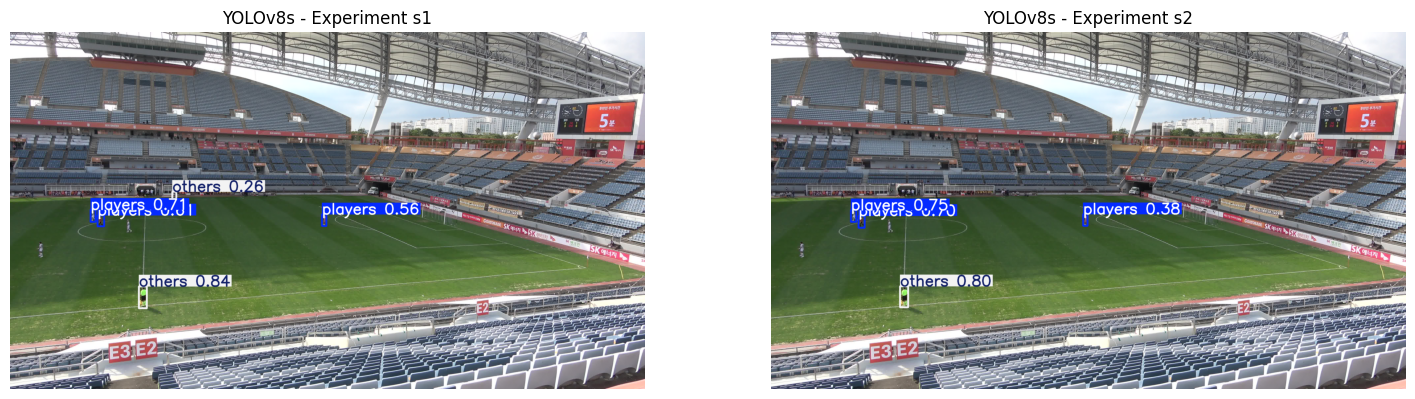

In [28]:
plt.figure(figsize=(18,9))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img_s1, cv2.COLOR_BGR2RGB))
plt.title("YOLOv8s - Experiment s1")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img_s2, cv2.COLOR_BGR2RGB))
plt.title("YOLOv8s - Experiment s2")
plt.axis("off")

plt.show()

In [29]:
CLASS_NAMES = {0: "players", 1: "ball", 2: "others"}

def count_by_class(result):
    counts = {v: 0 for v in CLASS_NAMES.values()}
    for c in result[0].boxes.cls:
        counts[CLASS_NAMES[int(c)]] += 1
    return counts

print("s1 class counts:", count_by_class(res_s1))
print("s2 class counts:", count_by_class(res_s2))

s1 class counts: {'players': 3, 'ball': 0, 'others': 2}
s2 class counts: {'players': 3, 'ball': 0, 'others': 1}
